# Food Dataset Analysis (EDA)

### Suggestions / Things to Explore in EDA (both datasets):

Note: for each insight found about the dataset, it is recommended to explain what it tells us about the dataset, why it's significant, 

- [ ] **Dataset directory and split integrity:** verify the expected Food-101 structure and examine the `/root/.cache/kagglehub/datasets/rkuo2000/uecfood256/versions/1/UECFOOD256` directory and contents. Confirm class counts match expectations (1,000 images per class)
- [ ] **Image resolutions and aspect ratios:** plot width / height histograms, aspect ratios, resolution scatter, and detect outliers
- [ ] **Brightness / contrast and dynamic range:** inspect pixel intensity histograms and per-image mean/std. Find and keep note of any overly dark, blown-out, or low-contrast classes (for normalization)
- [ ] **Sharpness / blur and quality issues:** use Laplacian variance for blur scores to identify classes with many blurry images


### UEC-Food256 Dataset
Things to consider while looking / exploring dataset

- [ ] **Dataset directory names:** as you can see when you first download the dataset, the folders are named as numbers (1-256). It would be a good idea to rename each folder based on the `category.txt` file which stores the name and id
  - After renaming, check to see if there are any folders of the same name. If there are, decide to merge or keep separate with reasoning.
- [ ]

### Resources:
(may be helpful)
*   https://neptune.ai/blog/data-exploration-for-image-segmentation-and-object-detection
*   https://medium.com/@juanabascal78/exploratory-image-analysis-part-1-advanced-density-plots-19b255075dbd
*   https://www.datacamp.com/tutorial/seeing-like-a-machine-a-beginners-guide-to-image-analysis-in-machine-learning

## Import + Download Dataset

In [1]:
%pip install python-dotenv
%pip install roboflow


Note: you may need to restart the kernel to use updated packages.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.8/54.8 MB 17.9 MB/s  0:00:03m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 892.3/892.3 kB 15.0 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 20.8 MB/s  0:00:00
  Attempting uninstall: idna╺━━━━━━━━━━━━━━━━━━━ 3/6 [opencv-python-headless]
    Found existing installation: idna 3.11m━━━━━━━━━━━━━━━━━━━ 3/6 [opencv-python-headless]
    Uninstalling idna-3.11:m╺━━━━━━━━━━━━━━━━━━━ 3/6 [opencv-python-headless]
      Successfully uninstalled idna-3.1190m━━━━━━━━━━━━━━━━━━━ 3/6 [opencv-python-headless]
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6/6 [roboflow]4/6 [idna]thon-headless]
Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install kagglehub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [kagglehub]
Note: you may need to restart the kernel to use updated packages.


In [11]:
# RUN FOR UEC-FOOD256 DATASET

import kagglehub 
# Download latest version 
path = kagglehub.dataset_download("rkuo2000/uecfood256")
print("Path to dataset files:", path)

Resuming download from 2155872256 bytes (2075984473 bytes left)...
Resuming download to C:\Users\msgal\.cache\kagglehub\datasets\rkuo2000\uecfood256\1.archive (2155872256/4231856729) bytes left.


100%|██████████| 3.94G/3.94G [08:52<00:00, 3.90MB/s]

Extracting files...


Path to dataset files: C:\Users\msgal\.cache\kagglehub\datasets\rkuo2000\uecfood256\versions\1


In [4]:
# RUN FOR YUSUF FOOD DATASET

from roboflow import Roboflow
from dotenv import load_dotenv
import os

load_dotenv()  # loads variables from .env into the environment

api_key = os.getenv("YUSUF_API_KEY")

rf = Roboflow(api_key=api_key) 
project = rf.workspace("caretech").project("food-dataset-uj20h-w2s4m")
version = project.version(1)
dataset = version.download("yolov8")


loading Roboflow workspace...
loading Roboflow project...


In [2]:
import os

for subdir, dirs, files in os.walk("vitamin-tracking/partner1-nathan_partner2-rohan/Food-Dataset-1"):
    print(f"{subdir} → {len(files)} files")

In [11]:
# rename uec food 256 directories

import os
import re
import shutil

DATA_ROOT = os.path.join("/Food-Dataset-1", "UECFOOD256")
CATEGORY_TXT_PATH = os.path.join("/Food-Dataset-1", "UECFOOD256","category.txt")


def sanitize_name(name: str) -> str:
  """
  make a filesystem-safe folder name
  - lowercase
  - trim
  - replace spaces with underscores
  - remove non-alphanumeric characters
  """
  s = name.strip().lower()
  s = s.replace("’", "'")  # normalize curly apostrophes
  s = s.replace('"', '')
  s = s.replace("/", " ")  # avoid path separators
  s = s.replace("\\", " ")
  s = s.replace("&", " and ")
  s = s.replace("+", " plus ")
  s = s.replace("–", "-").replace("—", "-")  # dashes
  s = s.replace("’", "'")
  s = s.replace("’", "'")
  # replace whitespace with underscores
  s = re.sub(r"\s+", "_", s)
  # remove invalid chars (keep a-z0-9 _ - . ')
  s = re.sub(r"[^a-z0-9_\-\.']", "", s)
  # collapse underscores
  s = re.sub(r"_+", "_", s)
  # strip leading/trailing underscores or dots
  s = s.strip("._")
  # fall back if empty
  if not s:
    s = "unnamed"
  return s


def parse_category_txt(path: str) -> dict:
  """
  parse category.txt file
  @return dict mapping numeric id (str) -> sanitized_name
  """
  id_to_name = {}
  if not os.path.isfile(path):
    raise FileNotFoundError(f"category.txt not found at {path}")
  with open(path, "r", encoding="utf-8") as f:
    for line in f:
      line = line.strip()
      if not line or line.startswith("#"):
        continue
      # Lines may be "id  name" with multiple spaces; first token is id, rest is name
      parts = re.split(r"\s+", line, maxsplit=1)
      if len(parts) != 2:
        # skip headers like "id  name"
        continue
      id_str, raw_name = parts
      if not id_str.isdigit():
        continue
      safe = sanitize_name(raw_name)
      id_to_name[id_str] = safe
  return id_to_name


def rename_dirs(root: str, id_to_name: dict, dry_run: bool = False) -> list:
  """
  Rename directories in root from numeric id to category name
  @return list of (old_path, new_path)
  """
  changes = []
  if not os.path.isdir(root):
    raise NotADirectoryError(f"Root path not found: {root}")

  # list only top-level directories
  for entry in os.listdir(root):
    old_path = os.path.join(root, entry)
    if not os.path.isdir(old_path):
      continue
    if not entry.isdigit():
      # Already renamed or a non-id dir like 'UECFOOD256' or 'category.txt' parent; skip
      continue
    id_str = entry
    if id_str not in id_to_name:
      print(f"Warning: id {id_str} not found in category.txt. Skipping.")
      continue
    base_name = id_to_name[id_str]
    new_name = base_name
    new_path = os.path.join(root, new_name)

    # resolve collisions
    if os.path.exists(new_path):
      # If target already exists and is the same folder (unlikely), skip
      # Else append id to make it unique
      alt_name = f"{base_name}_{id_str}"
      alt_path = os.path.join(root, alt_name)
      if os.path.exists(alt_path):
        # As a last resort append a numeric suffix
        suffix = 2
        while True:
          candidate = f"{base_name}_{id_str}_{suffix}"
          candidate_path = os.path.join(root, candidate)
          if not os.path.exists(candidate_path):
            new_name = candidate
            new_path = candidate_path
            break
          suffix += 1
      else:
          new_name = alt_name
          new_path = alt_path

    if dry_run:
      print(f"[DRY RUN] Would rename: {old_path} -> {new_path}")
    else:
      os.rename(old_path, new_path)
      changes.append((old_path, new_path))
      print(f"Renamed: {old_path} -> {new_path}")
  print("changes: ", changes)
  return changes



print(f"Reading categories from: {CATEGORY_TXT_PATH}")
id_to_name = parse_category_txt(CATEGORY_TXT_PATH)
print(f"Parsed {len(id_to_name)} categories.")

# preview changes first
print("\nPreview (dry run):")
rename_dirs(DATA_ROOT, id_to_name, dry_run=True)

# if preview looks good, do actual rename
proceed = True
if proceed:
    print("\nApplying renames:")
    changes = rename_dirs(DATA_ROOT, id_to_name, dry_run=False)
    print(f"\nDone. Renamed {len(changes)} folders.")
else:
    print("\nNo changes applied.")

Reading categories from: /Food-Dataset-1/UECFOOD256/category.txt


FileNotFoundError: category.txt not found at /Food-Dataset-1/UECFOOD256/category.txt

In [10]:
# Sanity Check Dataset (we are working with the Yusuf Dataset)

import os

DATASET_PATH = dataset.location

TRAIN_IMAGES = os.path.join(DATASET_PATH, "train/images")
TRAIN_LABELS = os.path.join(DATASET_PATH, "train/labels")

VAL_IMAGES = os.path.join(DATASET_PATH, "valid/images")
VAL_LABELS = os.path.join(DATASET_PATH, "valid/labels")

TEST_IMAGES = os.path.join(DATASET_PATH, "test/images")
TEST_LABELS = os.path.join(DATASET_PATH, "test/labels")

print("Train images:", len(os.listdir(TRAIN_IMAGES)))
print("Train labels:", len(os.listdir(TRAIN_LABELS)))
print("Val images:", len(os.listdir(VAL_IMAGES)))
print("Val labels:", len(os.listdir(VAL_LABELS)))
print("Test images:", len(os.listdir(TEST_IMAGES)))
print("Test labels:", len(os.listdir(TEST_LABELS)))



Train images: 3917
Train labels: 3917
Val images: 982
Val labels: 982
Test images: 11
Test labels: 11


In [11]:
# Check for any missing labels
import glob

train_images = sorted(glob.glob(os.path.join(TRAIN_IMAGES, "*")))
missing_labels = []

for img_path in train_images:
    base = os.path.splitext(os.path.basename(img_path))[0]
    label_path = os.path.join(TRAIN_LABELS, base + ".txt")
    if not os.path.exists(label_path):
        missing_labels.append(base)

print(f"Missing labels in training set: {len(missing_labels)}")


Missing labels in training set: 0


In [21]:
# Check Class Distribution
from collections import Counter
import pandas as pd
import yaml

# Load class names from data.yaml
with open(os.path.join(DATASET_PATH, "data.yaml")) as f:
    data_yaml = yaml.safe_load(f)

class_names = data_yaml["names"]

label_dir = os.path.join(DATASET_PATH, "train", "labels")
class_counts = Counter()

for label_file in glob.glob(os.path.join(label_dir, "*.txt")):
    with open(label_file) as f:
        for line in f:
            class_id = int(line.split()[0])
            class_counts[class_id] += 1

df_class_dist = pd.DataFrame(
    [(k, v, class_names[k]) for k, v in class_counts.items()],
    columns=["class_id", "bbox_count", "class_name"]
).sort_values("bbox_count", ascending=False)

df_class_dist


,class_id,bbox_count,class_name
12,20,472,rice
2,19,260,ramen-noodle
20,3,197,beef-curry
21,14,185,hamburger
10,30,158,toast
0,12,139,fried-rice
24,22,130,sandwiches
26,17,123,pork-cutlet-on-rice
17,25,122,sushi
18,16,118,pizza


100%|██████████| 3917/3917 [00:04<00:00, 787.92it/s]


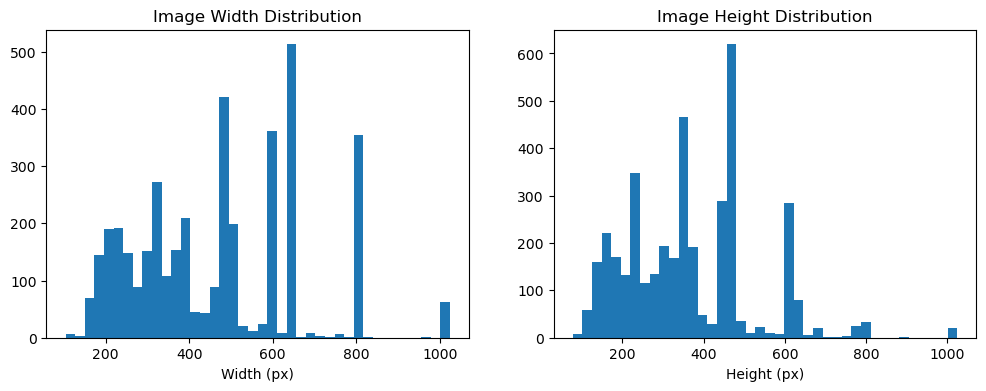

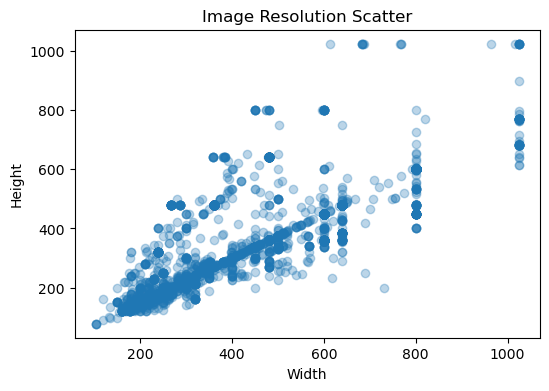

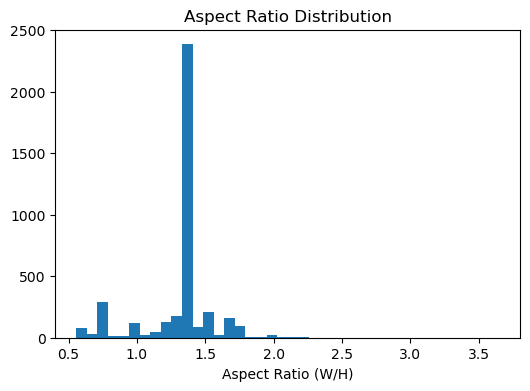

In [13]:
# Image Resolutions and Aspect Ratios

import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import glob
import os

train_images = glob.glob(os.path.join(TRAIN_IMAGES, "*"))

widths, heights = [], []

for img_path in tqdm(train_images):
    img = cv2.imread(img_path)
    if img is None:
        continue
    h, w = img.shape[:2]
    widths.append(w)
    heights.append(h)

widths = np.array(widths)
heights = np.array(heights)
aspect_ratios = widths / heights

# Width / Height histograms
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.hist(widths, bins=40)
plt.title("Image Width Distribution")
plt.xlabel("Width (px)")

plt.subplot(1,2,2)
plt.hist(heights, bins=40)
plt.title("Image Height Distribution")
plt.xlabel("Height (px)")

plt.show()

# Resolution scatter
plt.figure(figsize=(6,4))
plt.scatter(widths, heights, alpha=0.3)
plt.xlabel("Width")
plt.ylabel("Height")
plt.title("Image Resolution Scatter")
plt.show()

# Aspect ratio
plt.figure(figsize=(6,4))
plt.hist(aspect_ratios, bins=40)
plt.xlabel("Aspect Ratio (W/H)")
plt.title("Aspect Ratio Distribution")
plt.show()

100%|██████████| 3917/3917 [00:07<00:00, 517.09it/s]


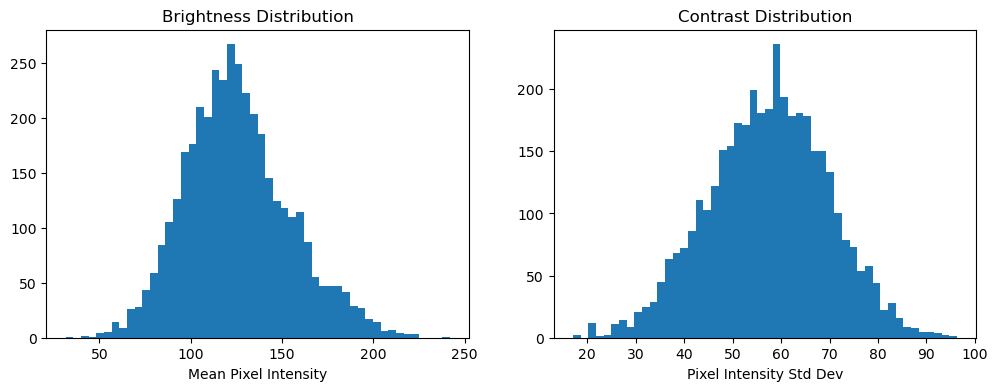

In [14]:
# Brightness / Contrast and Dynamic Range

mean_intensity = []
std_intensity = []

for img_path in tqdm(train_images):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        continue
    mean_intensity.append(img.mean())
    std_intensity.append(img.std())

mean_intensity = np.array(mean_intensity)
std_intensity = np.array(std_intensity)

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.hist(mean_intensity, bins=50)
plt.xlabel("Mean Pixel Intensity")
plt.title("Brightness Distribution")

plt.subplot(1,2,2)
plt.hist(std_intensity, bins=50)
plt.xlabel("Pixel Intensity Std Dev")
plt.title("Contrast Distribution")

plt.show()

100%|██████████| 3917/3917 [00:14<00:00, 266.57it/s]


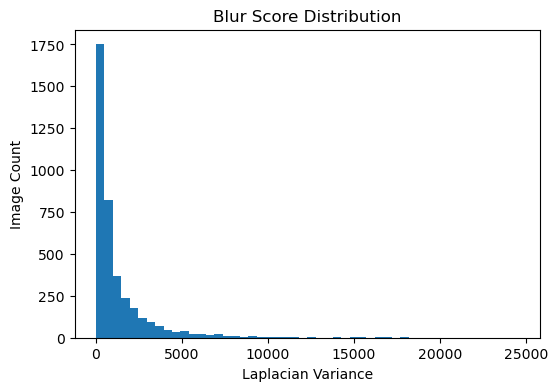

Proportion of potentially blurry images (<100): 9.78%


In [15]:
# Sharpness, Blurriness, and Quality

def laplacian_variance(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return cv2.Laplacian(gray, cv2.CV_64F).var()

blur_scores = []

for img_path in tqdm(train_images):
    img = cv2.imread(img_path)
    if img is None:
        continue
    blur_scores.append(laplacian_variance(img))

blur_scores = np.array(blur_scores)

plt.figure(figsize=(6,4))
plt.hist(blur_scores, bins=50)
plt.xlabel("Laplacian Variance")
plt.ylabel("Image Count")
plt.title("Blur Score Distribution")
plt.show()

# Identify potentially blurry images (example threshold)
blurry_ratio = (blur_scores < 100).mean()
print(f"Proportion of potentially blurry images (<100): {blurry_ratio:.2%}")

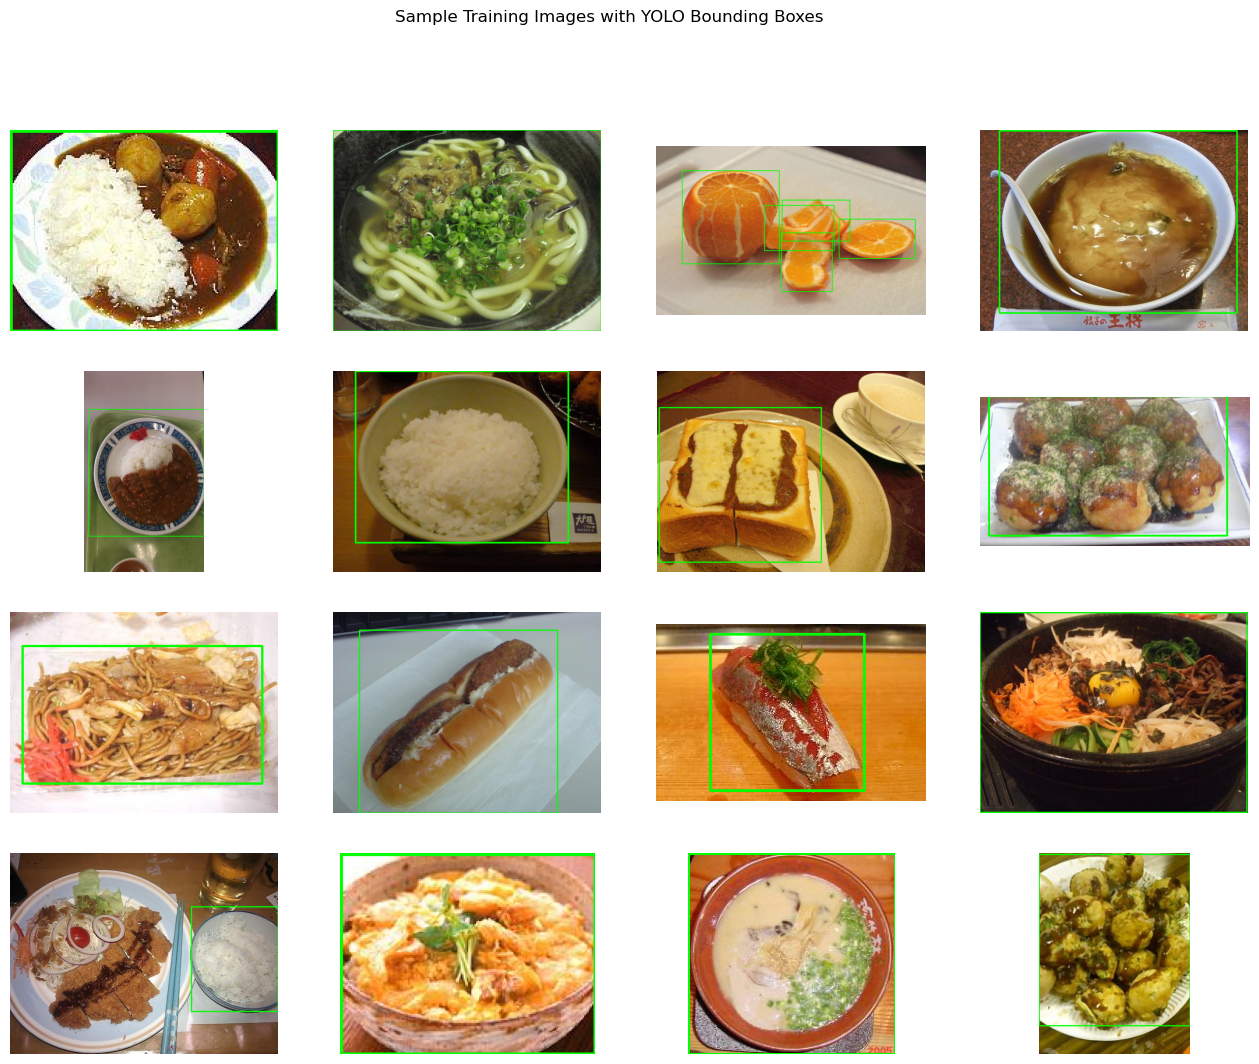

In [16]:
# Sample Visuals

import random
import cv2
import matplotlib.pyplot as plt
import os
import glob

train_images = glob.glob(os.path.join(TRAIN_IMAGES, "*"))
train_labels = TRAIN_LABELS

def draw_yolo_boxes(img, label_path):
    h, w = img.shape[:2]
    if not os.path.exists(label_path):
        return img

    with open(label_path) as f:
        for line in f:
            cls, xc, yc, bw, bh = map(float, line.split())

            x1 = int((xc - bw / 2) * w)
            y1 = int((yc - bh / 2) * h)
            x2 = int((xc + bw / 2) * w)
            y2 = int((yc + bh / 2) * h)

            cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)

    return img

# Select 16 random images (12–24 recommended)
samples = random.sample(train_images, 16)

plt.figure(figsize=(16, 12))

for i, img_path in enumerate(samples):
    img = cv2.imread(img_path)

    label_path = os.path.join(
        train_labels,
        os.path.basename(img_path).replace(".jpg", ".txt")
    )

    img = draw_yolo_boxes(img, label_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(4, 4, i + 1)
    plt.imshow(img)
    plt.axis("off")

plt.suptitle("Sample Training Images with YOLO Bounding Boxes")
plt.show()

In [19]:
# Split dataset

import os
import glob
import random
from collections import Counter, defaultdict

RANDOM_SEED = 42
random.seed(RANDOM_SEED)

IMAGES_DIR = os.path.join(DATASET_PATH, "train", "images")
LABELS_DIR = os.path.join(DATASET_PATH, "train", "labels")

image_paths = sorted(glob.glob(os.path.join(IMAGES_DIR, "*")))

# Stratified split
image_to_class = {}

for img_path in image_paths:
    base = os.path.splitext(os.path.basename(img_path))[0]
    label_path = os.path.join(LABELS_DIR, base + ".txt")

    class_counts = Counter()
    with open(label_path) as f:
        for line in f:
            cls = int(line.split()[0])
            class_counts[cls] += 1

    image_to_class[img_path] = class_counts.most_common(1)[0][0]


# Split per class deterministically
class_to_images = defaultdict(list)
for img, cls in image_to_class.items():
    class_to_images[cls].append(img)

train_split, val_split, test_split = [], [], []

for imgs in class_to_images.values():
    random.shuffle(imgs)
    n = len(imgs)

    n_train = int(0.7 * n)
    n_val = int(0.2 * n)

    train_split.extend(imgs[:n_train])
    val_split.extend(imgs[n_train:n_train + n_val])
    test_split.extend(imgs[n_train + n_val:])

random.shuffle(train_split)
random.shuffle(val_split)
random.shuffle(test_split)

print(len(train_split), len(val_split), len(test_split))

# Save manifest files
OUTPUT_DIR = "splits/"
os.makedirs(OUTPUT_DIR, exist_ok=True)

def write_manifest(paths, out_file):
    with open(out_file, "w") as f:
        for img_path in paths:
            rel_img = os.path.relpath(img_path, DATASET_PATH)
            rel_lbl = rel_img.replace("images", "labels").rsplit(".", 1)[0] + ".txt"
            f.write(f"{rel_img} {rel_lbl}\n")

write_manifest(train_split, os.path.join(OUTPUT_DIR, "train.txt"))
write_manifest(val_split, os.path.join(OUTPUT_DIR, "val.txt"))
write_manifest(test_split, os.path.join(OUTPUT_DIR, "test.txt"))

2728 773 416
